In [65]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d, gaussian_kde
from numba import njit
from astropy.io import fits, ascii
import astropy.coordinates as coord
import astropy.units as u
from scipy.ndimage import gaussian_filter

from astropy.coordinates import SkyCoord, Galactic, Galactocentric
from astropy import units as u

from joblib import Parallel, delayed

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
sys.path.append(basepath+'note/')

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0, where=a>0), where=a>0)

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    if isinstance(ans, float):
        if a <= 0:
            ans = np.nan
    else:
        ans[a <= 0] = np.nan
    
    return ans

In [80]:
meta = {}
meta['snap_list'] = np.arange(100)
# meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    # meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))
    del header
    
meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [11]:
%%time
snapnum = 40
sub_fields = ['SubhaloSFRinRad', 'SubhaloMassInRadType', 'SubhaloParent', 
              'SubhaloHalfmassRadType', 'SubhaloPos']
subs = il.groupcat.loadSubhalos(TNGbase, snapnum, fields=sub_fields)

halo_fields = ['GroupFirstSub', 'GroupMassType']
halos = il.groupcat.loadHalos(TNGbase, snapnum, fields=halo_fields)

arr = halos['GroupFirstSub']
arr = arr[arr >= 0]
is_central = np.full(len(subs['SubhaloSFRinRad']), False)
is_central[arr] = True

stmass = subs['SubhaloMassInRadType'][:,4]
logstmass = np.log10(1e10*stmass, where=stmass > 0)
in_massband = np.logical_and(10 < logstmass, logstmass < 10.5)

is_central_in_massband = np.logical_and(is_central, in_massband)
subIDs = np.where(is_central_in_massband)[0]

CPU times: user 2.15 s, sys: 4.09 s, total: 6.24 s
Wall time: 35.3 s


In [12]:
np.random.seed(42)
subIDs_toplot = np.concatenate([[172175],np.random.choice(subIDs, 16, replace=False)])
assert len(np.unique(subIDs_toplot)) == len(subIDs_toplot)

In [13]:
def get_SFH(snapnum, subID, tbins, logFeH0_list, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    sub = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - sub['SubhaloPos']
    r = np.linalg.norm(pos, axis=1)
    rhalf = sub['SubhaloHalfmassRadType'][4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    sfh = np.zeros((len(tbins)-1, len(logFeH0_list)+1))
    
    dt = tbins[1] - tbins[0]
    sfh[:,0], edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    # now split by Fe, Mg
    GFM_SOLAR_ABUNDANCE_HYDROGEN  = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON      = 0.0013
    GFM_SOLAR_ABUNDANCE_OXYGEN    = 0.0057
    GFM_SOLAR_ABUNDANCE_NEON      = 0.0012
    GFM_SOLAR_ABUNDANCE_SILICON   = 0.0007
    
    FeH = snap['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    # MgH = snap['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    # MgH = snap['GFM_Metals'][:,4] / GFM_SOLAR_ABUNDANCE_OXYGEN
    # MgH = snap['GFM_Metals'][:,5] / GFM_SOLAR_ABUNDANCE_NEON
    # MgH = snap['GFM_Metals'][:,5] / GFM_SOLAR_ABUNDANCE_NEON
    MgH = snap['GFM_Metals'][:,7] / GFM_SOLAR_ABUNDANCE_SILICON
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH0 = 0.05
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        in_SN   = np.logical_and(r > rhalf, r < 2*rhalf)
        is_star = snap['GFM_StellarFormationTime'] > 0
        is_star_in_SN = np.logical_and(is_star, in_SN)
        key_    = np.logical_and(np.logical_and(in_FeH, in_SN), is_star)
        
        sfh[:,i+1], edges = np.histogram(tform[key_], bins=tbins, weights=10*mass[key_]/dt/dlogFeH0)
        
        keys.append(key_)
    
    return tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN


In [14]:
# def get_MW_plot_data(N_FeH=128, N_MgFe=128, logFeH_lim=(-1.5, 0.5), logMgFe_lim=(-0.2, 0.8),
#                      logFeH0_list = [-0.5, -0.25, 0, 0.25]):
# # N_FeH = 128
# # N_MgFe = 128
# # logFeH_lim = (-1.5, 0.5)
# # logMgFe_lim = (-0.2, 0.8)
# # if True:
#     hdul = fits.open('../../data/allStar-dr17-synspec_rev1.fits')
    
#     # first do quality cuts
#     no_starflag = hdul[1].data.STARFLAG == 0
#     good_snr = hdul[1].data.SNR > 200
#     good_vscatter = hdul[1].data.VSCATTER < 1
#     good_parallax = hdul[1].data.GAIAEDR3_PARALLAX/hdul[1].data.GAIAEDR3_PARALLAX_ERROR > 1
#     good_logg = np.logical_and(hdul[1].data.LOGG < 3.5, hdul[1].data.LOGG_ERR < 0.2)
#     good_nan_FeH = np.logical_not(np.isnan(hdul[1].data.FE_H))
#     good_nan_MgFe = np.logical_not(np.isnan(hdul[1].data.MG_FE))
    
#     aspcap_keys = np.logical_and(no_starflag, good_snr)
#     aspcap_keys = np.logical_and(aspcap_keys, good_vscatter)
#     aspcap_keys = np.logical_and(aspcap_keys, good_parallax)
#     aspcap_keys = np.logical_and(aspcap_keys, good_logg)
#     aspcap_keys = np.logical_and(aspcap_keys, good_nan_FeH)
#     aspcap_keys = np.logical_and(aspcap_keys, good_nan_MgFe)
    
#     # Define your data
#     ra = hdul[1].data.RA * u.deg
#     dec = hdul[1].data.DEC * u.deg
#     parallax = hdul[1].data.GAIAEDR3_PARALLAX * u.mas

#     pmra = hdul[1].data.GAIAEDR3_PMRA * u.mas/u.yr
#     pmdec = hdul[1].data.GAIAEDR3_PMDEC * u.mas/u.yr
#     rv = hdul[1].data.VHELIO_AVG * u.km/u.s

#     # Convert parallax to distance
#     distance = parallax.to(u.pc, equivalencies=u.parallax())

#     # Create a SkyCoord object
#     coords = SkyCoord(ra=ra, dec=dec, distance=distance, 
#                       pm_ra_cosdec=pmra, pm_dec=pmdec, 
#                       radial_velocity=rv, frame='icrs')

#     # Convert to Galactocentric coordinates
#     gal_coord = coords.transform_to(Galactocentric())

#     # Now you can access the galactocentric coordinates
#     x, y, z = gal_coord.x, gal_coord.y, gal_coord.z
#     vx, vy, vz = gal_coord.v_x, gal_coord.v_y, gal_coord.v_z

#     # compute angular momenta
#     Lz = x * vy - y * vx
#     Lzsun = -Galactocentric().galcen_distance * Galactocentric().galcen_v_sun.d_y
    
#     # Apply keys
#     SN_key = np.abs((Lz-Lzsun)/Lzsun) < 0.2
#     SN_key = np.logical_and(SN_key, np.abs(z) < 3*u.kpc)
#     SN_key = np.logical_and(SN_key, aspcap_keys)
    
#     # Get chemistry
#     logFeH = hdul[1].data.FE_H[SN_key]
#     logMgFe = hdul[1].data.MG_FE[SN_key]
    
#     logFeH_err = hdul[1].data.FE_H_ERR[SN_key]
#     logMgFe_err = hdul[1].data.MG_FE_ERR[SN_key]
    
#     # Create bins
#     FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
#     MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
#     dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
#     dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
#     # Calculate the midpoints of each bin
#     FeH_centers = (FeH_bins[:-1] + FeH_bins[1:]) / 2
#     MgFe_centers = (MgFe_bins[:-1] + MgFe_bins[1:]) / 2

#     # Create a meshgrid of all combinations of MgFe and FeH centers
#     FeH_grid, MgFe_grid = np.meshgrid(FeH_centers, MgFe_centers, indexing='ij')

#     # Stack the grids to create an array of shape (200, 2)
#     bin_centers = np.vstack([FeH_grid.ravel(), MgFe_grid.ravel()])
    
#     # Create gaussian kde of fid data
#     data0 = np.vstack([logFeH, logMgFe])
#     kde0 = gaussian_kde(data0)
#     H0 = np.reshape(kde0(bin_centers), (N_FeH, N_MgFe))
#     H0 /= dFeH*dMgFe*np.sum(H0)
    
#     # Get keys
#     dlogFeH0 = 0.2
#     keys = []
#     for i,logFeH0 in enumerate(logFeH0_list):
#         in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
#         keys.append(in_FeH)
    
#     # Now get APOKASC2 ages
#     fname = '../../data/APOKASC2/table5.dat'
#     readme = '../../data/APOKASC2/ReadMe'
#     data = ascii.read(fname, readme=readme)
    
#     logage = data['LogAge']
#     logage_err_u = data['E_LogAge']
#     logage_err_l = data['e_LogAge']

#     age = 10.**logage
#     age_err_u = 10.**(logage_err_u + logage) - age
#     age_err_l = 10.**(logage_err_l + logage) - age

#     age /= 1000
#     age_err_u /= 1000
#     age_err_l /= 1000

#     age_err = np.maximum(age_err_u, -age_err_l)
    
#     # cross match with full APOGEE catalog
#     out = {}
    
#     out['ages'] = np.full_like(logFeH, np.nan)
#     out['age_err'] = np.full_like(logFeH, np.nan)
#     IDs = ['2M' + d for d in data['2MASS']]
#     apogeeIDs = hdul[1].data.APOGEE_ID[SN_key]
#     apogee_id_map = {ID: idx for idx, ID in enumerate(apogeeIDs)}
    
#     for i,ID in enumerate(tqdm(IDs)):
#         if ID in apogeeIDs and age_err[i]/age[i] < 0.25:
#             out['ages'][apogee_id_map[ID]] = age[i]
#             out['age_err'][apogee_id_map[ID]] = age_err[i]
            
#     # keys = np.array([apogee_id_map[ID] for ID in IDs])
#     # out['ages'][keys] = age
    
#     # print out sample size
#     print('num ASPCAP: ', len(logFeH))
#     print('num APOKASC2: ', np.sum(np.logical_not(np.isnan(out['ages']))))
    
#     out['logFeH']       = logFeH
#     out['logMgFe']      = logMgFe
#     out['logFeH_err']   = logFeH_err
#     out['logMgFe_err']  = logMgFe_err
#     out['N_FeH']        = N_FeH
#     out['N_MgFe']       = N_MgFe
#     out['logFeH_lim']   = logFeH_lim
#     out['logMgFe_lim']  = logMgFe_lim
#     out['FeH_centers']  = FeH_centers
#     out['MgFe_centers'] = MgFe_centers
#     out['H']            = H0
#     out['logFeH0_list'] = logFeH0_list
#     out['keys']         = keys
#     out['is_obs']       = True
    
#     return out
    

In [40]:
print(meta['redshift'][33])
print(meta['redshift'][40])
print(meta['redshift'][50])

2.0020281392528516
1.4955121664955557
0.9972942257819404


In [83]:
def get_sim_plot_data(subID, snapnum, slope=0, snapnum_slopes=(50, 40, 33), N_FeH=128, N_MgFe=128,
                 logFeH_lim=(-1.5, 0.5), logMgFe_lim=(0, 1.0),
                 logFeH0_list=[-0.75, -0.5, -0.25, 0]):
    # Load in data
    t_snapnum = meta['time'][snapnum]
    tbins = np.linspace(0, t_snapnum, 100)
    tlim = [tbins[0], tbins[-1]]
    tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN = \
        get_SFH(snapnum, subID, tbins, logFeH0_list)
    
    # Add slope to MgFe
    slope *= -1
    logMgFe_slope = []
    for snp in snapnum_slopes:
        t0 = meta['time'][snp]
        correct = slope * (tform - t0)
        correct[tform > t0] = 0
        logMgFe_slope.append(logMgFe + correct)
    
    # Create bins
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
    # Calculate the midpoints of each bin
    FeH_centers = (FeH_bins[:-1] + FeH_bins[1:]) / 2
    MgFe_centers = (MgFe_bins[:-1] + MgFe_bins[1:]) / 2

    # Create a meshgrid of all combinations of MgFe and FeH centers
    FeH_grid, MgFe_grid = np.meshgrid(FeH_centers, MgFe_centers, indexing='ij')

    # Stack the grids to create an array of shape (200, 2)
    bin_centers = np.vstack([FeH_grid.ravel(), MgFe_grid.ravel()])
    
    # Create gaussian kde of fid data
    data0 = np.vstack([logFeH[is_star_in_SN], logMgFe[is_star_in_SN]])
    kde0 = gaussian_kde(data0)
    H0 = np.reshape(kde0(bin_centers), (N_FeH, N_MgFe))
    # H0 /= dFeH*dMgFe
    H0 /= (dFeH*dMgFe*np.sum(H0))
    
    # Create gaussian kde of sloped data
    H_slp = []
    for i in range(len(snapnum_slopes)):
        data1 = np.vstack([logFeH[is_star_in_SN], logMgFe_slope[i][is_star_in_SN]])
        kde1 = gaussian_kde(data1)
        H1 = np.reshape(kde1(bin_centers), (N_FeH, N_MgFe))
        # H1 /= dFeH*dMgFe
        H1 /= (dFeH*dMgFe*np.sum(H1))
        H_slp.append(H1)
        
    
    # store in output
    out = {}
    out_slope0 = {}
    out_slope1 = {}
    out_slope2 = {}
    
    for o in [out, out_slope0, out_slope1, out_slope2]:
        o['N_FeH']         = N_FeH
        o['N_MgFe']        = N_MgFe
        o['logFeH_lim']    = logFeH_lim
        o['logMgFe_lim']   = logMgFe_lim
        o['logFeH0_list']  = logFeH0_list
        o['subID']         = subID
    
        o['tcenter']       = tcenter
        o['sfh']           = sfh
        o['tform']         = tform
        o['logFeH']        = logFeH
        o['keys']          = keys
        o['is_star_in_SN'] = is_star_in_SN
        o['tbins']         = tbins
    
        o['FeH_bins']      = FeH_bins
        o['MgFe_bins']     = MgFe_bins
        o['FeH_centers']   = FeH_centers
        o['MgFe_centers']  = MgFe_centers
        o['is_obs']        = False
    
    out['H'] = H0
    out['logMgFe']       = logMgFe
    
    out_slope0['slope']   = slope
    out_slope0['logMgFe'] = logMgFe_slope[0]
    out_slope0['H'] = H_slp[0]
    
    out_slope1['slope']   = slope
    out_slope1['logMgFe'] = logMgFe_slope[1]
    out_slope1['H'] = H_slp[1]
    
    out_slope2['slope']   = slope
    out_slope2['logMgFe'] = logMgFe_slope[2]
    out_slope2['H'] = H_slp[2]
       
    return out, out_slope0, out_slope1, out_slope2

In [16]:
# def plot_panel(fig, ax0, ax1, dat, vmin=None, vmax=None, levels=[0.1, 1.5, 10]):
    
#     logFeH_lim    = dat['logFeH_lim']
#     logMgFe_lim   = dat['logMgFe_lim']
#     logFeH0_list  = dat['logFeH0_list']
#     N_FeH         = dat['N_FeH']
#     N_MgFe        = dat['N_MgFe']
#     FeH_centers   = dat['FeH_centers']
#     MgFe_centers  = dat['MgFe_centers']
#     logFeH        = dat['logFeH']
#     logMgFe       = dat['logMgFe']
#     keys          = dat['keys']
#     H             = dat['H']
    
#     extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
#     norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
#     im = ax0.imshow(H.T, origin='lower', extent=extent,
#                     cmap='Greys', norm=norm, interpolation='None')
#     cont = ax0.contour(FeH_centers, MgFe_centers, H.T, levels, colors='red', linewidths=1)
    
#     ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
#     ax0.set_aspect('auto')
    
#     ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    
#     # ------- MgFe hist ------- #
#     cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']
#     cs = [tb_c[0], tb_c[1], tb_c[4], tb_c[2]]
    
#     dlogFeH0 = 0.05
#     d = 0.25/2
#     # offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
#     # bins = np.linspace(-d, 1+d, 200+1)
#     # binsplot = 0.5*(bins[1:] + bins[:-1])
    
#     offset_list = [0, 0, 0, 0]
#     bins = np.linspace(-0.3, 0.3, 100+1)
#     binsplot = 0.5*(bins[1:] + bins[:-1])
    
#     for i,(logFeH0, c, key) in enumerate(zip(logFeH0_list, cs, keys)):
#         offset = offset_list[i]
        
#         hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key])+offset, 
#                                bins=bins, density=True)
#         l = ax1.plot(binsplot, hist, lw=1)
        
#         ax0.axvline(logFeH0, c=c)
    
#     ax1.set_xticks(np.arange(-0.3, 1.3+0.1, 0.1), minor=True)
    
#     ax1.set(ylim=(0, 20), xlim=(bins[0], bins[-1]))
    
#     ax1.set(xlabel=r'$[\,\textrm{Mg}/\textrm{Fe}\,]+\textrm{ offset}$')
    
   
               

# def make_plot(MWdat, simdat, simdat_slope, save=False, show=True, vmin=None, vmax=None,
#               fname='tmp.pdf', levels=[0.1, 1.5, 10], levels_MW=[0.1, 1.5, 10]):
    
#     fig, axs = plt.subplots(2, 3, figsize=(textwidth, 1.2*columnwidth))
    
#     plot_panel(fig, axs[0][0], axs[1][0], MWdat, vmin=vmin, vmax=vmax, levels=levels_MW)
#     axs[0][0].set_title(r'$\textrm{Milky Way}$')
               
#     plot_panel(fig, axs[0][1], axs[1][1], simdat, vmin=vmin, vmax=vmax, levels=levels)
#     axs[0][1].set_title(r'$\textrm{fiducial }' + str(simdat['subID'])+r'$')
    
#     plot_panel(fig, axs[0][2], axs[1][2], simdat_slope, vmin=vmin, vmax=vmax, levels=levels)
#     axs[0][2].set_title(r'$\alpha\textrm{-enhanced }' + str(simdat['subID']) + r'$')
    
#     fig.tight_layout()
    
#     if save:
#         fig.savefig(fname)
        
#     if not show:
#         plt.close()

In [60]:
def plot_panel(fig, ax0, ax1, dat, vmin=None, vmax=None, levels=[0.1, 1.5, 10]):
    
    logFeH_lim    = dat['logFeH_lim']
    logMgFe_lim   = dat['logMgFe_lim']
    logFeH0_list  = dat['logFeH0_list']
    N_FeH         = dat['N_FeH']
    N_MgFe        = dat['N_MgFe']
    FeH_centers   = dat['FeH_centers']
    MgFe_centers  = dat['MgFe_centers']
    logFeH        = dat['logFeH']
    logMgFe       = dat['logMgFe']
    keys          = dat['keys']
    H             = dat['H']
    
    extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    im = ax0.imshow(H.T, origin='lower', extent=extent,
                    cmap='Greys', norm=norm, interpolation='None')
    cont = ax0.contour(FeH_centers, MgFe_centers, H.T, levels, colors='k', linestyles='dashed', 
                       alpha=0.5, linewidths=1)
    
    ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax0.set_aspect('auto')
    
    ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    
    # ------- MgFe hist ------- #
    cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']
    cs = [tb_c[0], tb_c[1], tb_c[4], tb_c[2]]
    
    dlogFeH0 = 0.05
    d = 0.25/2
 
    offset_list = [0, 11, 22, 33]
    bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], 64+1)
    binsplot = 0.5*(bins[1:] + bins[:-1])
    
    for i,(logFeH0, c, key) in enumerate(zip(logFeH0_list, cs, keys)):
        offset = offset_list[i]
        
        # hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key]), bins=bins, density=True)
        hist, _ = np.histogram(logMgFe[key], bins=bins, density=True)
        l = ax1.plot(binsplot, hist+offset, lw=1)
        
        # if i==0:
            # ax0.axvline(logFeH0, c=c, lw=lw)
        ax0.fill_between([logFeH0-dlogFeH0/2, logFeH0+dlogFeH0/2],
                         [logMgFe_lim[0], logMgFe_lim[0]],
                         [logMgFe_lim[1], logMgFe_lim[1]], facecolor=c, alpha=0.8)
        
        if i > 0:
            ax1.axhline(offset, c='k', lw=1, alpha=0.8)
    
    # ax1.set_xticks(np.arange(-0.3, 1.3+0.1, 0.1), minor=True)
    ax1.set_yticks([])
    
    ax1.set(ylim=(0, 50), xlim=logMgFe_lim)
    
    ax1.set(xlabel=r'$[\,\textrm{Mg}/\textrm{Fe}\,]+\textrm{ offset}$')
    
    ax0.set_xticks(np.arange(logFeH_lim[0], logFeH_lim[1]+0.25, 0.25), minor=True)
    ax1.set_xticks(np.arange(logMgFe_lim[0], logMgFe_lim[1]+0.25, 0.1), minor=True)
    
   
               

def make_plot(dat0, dat1, dat2, dat3, save=False, show=False, vmin=None, vmax=None,
              fname='tmp.pdf', levels=[0.1, 1.5, 10], levels_MW=[0.1, 1.5, 10]):
    
    fig, axs = plt.subplots(2, 4, figsize=(textwidth, columnwidth))
    
    plot_panel(fig, axs[0][0], axs[1][0], dat0, vmin=vmin, vmax=vmax, levels=levels_MW)
    axs[0][0].set_title(r'$\textrm{fiducial }' + str(simdat['subID'])+r'$')
               
    plot_panel(fig, axs[0][1], axs[1][1], dat1, vmin=vmin, vmax=vmax, levels=levels)
    axs[0][1].set_title(r'$\alpha\textrm{-enhanced at }z=1$')
    
    plot_panel(fig, axs[0][2], axs[1][2], dat2, vmin=vmin, vmax=vmax, levels=levels)
    axs[0][2].set_title(r'$\alpha\textrm{-enhanced at }z=1.5$')
    
    plot_panel(fig, axs[0][3], axs[1][3], dat3, vmin=vmin, vmax=vmax, levels=levels)
    axs[0][3].set_title(r'$\alpha\textrm{-enhanced at }z=2$')
    
    
    fig.tight_layout()
    
    if save:
        fig.savefig(fname)
        
    if not show:
        plt.close()

In [53]:
%%time
N_FeH = 32
N_MgFe = 32
snapnum = 40
slope = 0.1
vmin = 0.08
vmax = 15

subID = subIDs_toplot[0]

treeMPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMDB=True)
key = treeMPB['SnapNum'] == 99
subID_z0 = treeMPB['SubfindID'][key][0]
simdat, simdat_slope1, simdat_slope15, simdat_slope2 = get_sim_plot_data(subID_z0, 99, slope=slope, 
                                                                         N_FeH=N_FeH, N_MgFe=N_MgFe)

CPU times: user 26.1 s, sys: 56.7 ms, total: 26.2 s
Wall time: 26.2 s


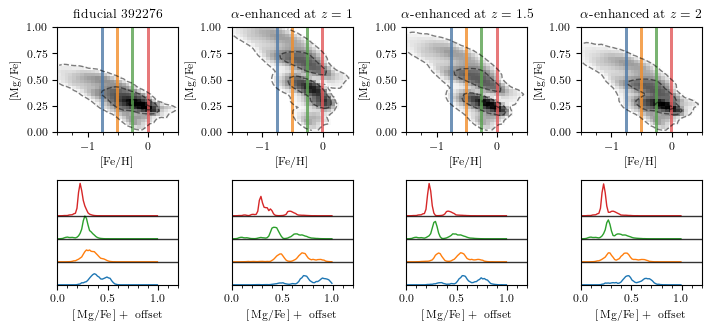

In [61]:
make_plot(simdat, simdat_slope1, simdat_slope15, simdat_slope2, vmin=vmin, vmax=vmax, save=False, show=True)

In [84]:
def get_single_sim_plot_data(subID, snapnum=40):
    N_FeH = 64
    N_MgFe = 64
    slope = 0.1
    
    treeMPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMDB=True)
    key = treeMPB['SnapNum'] == 99
    subID_z0 = treeMPB['SubfindID'][key][0]
    
    return get_sim_plot_data(subID_z0, 99, slope=slope, N_FeH=N_FeH, N_MgFe=N_MgFe)

In [85]:
out = Parallel(n_jobs=24)(delayed(get_single_sim_plot_data)(subID) for subID in tqdm(subIDs_toplot))

100%|██████████| 17/17 [00:00<00:00, 1428.12it/s]


In [91]:
vmin = 0.08
vmax = 15

for o in tqdm(out, leave=True, position=0):
    simdat = o[0]
    simdat_slope1 = o[1]
    simdat_slope15 = o[2]
    simdat_slope2 = o[3]
    subID = simdat['subID']
    
    # print(subID)
    
    make_plot(simdat, simdat_slope1, simdat_slope15, simdat_slope2,
              vmin=vmin, vmax=vmax, save=True, show=False, fname='app_'+str(subID)+'.pdf')

100%|██████████| 17/17 [00:22<00:00,  1.34s/it]


In [95]:
subIDs = []
for o in out:
    subIDs.append(o[0]['subID'])

for sID in np.sort(subIDs):
    if sID != 392276:
        print(sID)

2
10
143882
167392
289388
300903
348901
398784
404818
425719
439099
465255
494709
510273
547293
576516


In [90]:
snapnum = 40

for subID in subIDs_toplot:
    treeMDB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMDB=True)
    key = treeMDB['SnapNum'] == 99
    subID_z0 = treeMDB['SubfindID'][key][0]
    grnr = treeMDB['SubhaloGrNr'][key][0]
    print(subID, np.sum(treeMDB['SnapNum'] == 99), subID_z0, grnr)

172175 1 392276 46
260347 1 10 0
179009 1 348901 28
245661 1 494709 136
178140 1 167392 5
265671 1 547293 242
287601 1 576516 338
292983 1 2 0
196834 1 143882 4
235345 1 425719 65
202467 1 465255 99
163071 1 300903 18
282632 1 289388 16
254663 1 510273 161
193025 1 439099 76
208267 1 398784 49
222555 1 404818 52


In [33]:
list(treeMDB.keys())

['count',
 'DescendantID',
 'FirstProgenitorID',
 'FirstSubhaloInFOFGroupID',
 'GroupBHMass',
 'GroupBHMdot',
 'GroupCM',
 'GroupFirstSub',
 'GroupGasMetalFractions',
 'GroupGasMetallicity',
 'GroupLen',
 'GroupLenType',
 'GroupMass',
 'GroupMassType',
 'GroupNsubs',
 'GroupPos',
 'GroupSFR',
 'GroupStarMetalFractions',
 'GroupStarMetallicity',
 'GroupVel',
 'GroupWindMass',
 'Group_M_Crit200',
 'Group_M_Crit500',
 'Group_M_Mean200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_Crit500',
 'Group_R_Mean200',
 'Group_R_TopHat200',
 'LastProgenitorID',
 'MainLeafProgenitorID',
 'Mass',
 'MassHistory',
 'NextProgenitorID',
 'NextSubhaloInFOFGroupID',
 'NumParticles',
 'RootDescendantID',
 'SnapNum',
 'SubfindID',
 'SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloCM',
 'SubhaloGasMetalFractions',
 'SubhaloGasMetalFractionsHalfRad',
 'SubhaloGasMetalFractionsMaxRad',
 'SubhaloGasMetalFractionsSfr',
 'SubhaloGasMetalFractionsSfrWeighted',
 'SubhaloGasMetallicity',
 'SubhaloGasMetallicityHal